Functional alignment for a pair of subject on a Region of Interest (ROI)
===================================================================

In this tutorial, we show how to better predict new contrasts for a target /
    subject using source subject corresponding contrasts and data in common.

We mostly rely on python common packages and on nilearn to /
    handle functional data in a clean fashion.


To run this example, you must launch IPython via ``ipython
--matplotlib`` in a terminal, or use ``jupyter-notebook``.

.. contents:: **Contents**
    :local:
    :depth: 1

Retrieving the data
-------------------
In this example we use the IBC dataset, which include a large number of different contrasts maps for 12 subjects
We download the images for subjects 1 and 2 (or retrieve them if they were already downloaded)
* Files is the list of paths for each subjects.
* df is a dataframe with metadata about each of them.
* mask is an appropriate nifti image to select the data.

In [14]:
from fmralign.fetch_example_data import fetch_ibc_subjects_contrasts
files, df, mask = fetch_ibc_subjects_contrasts(
    ['sub-01', 'sub-02'])

Extract a mask for the visual cortex from Yeo Atlas
-----------------
First, we fetch and plot the complete atlas

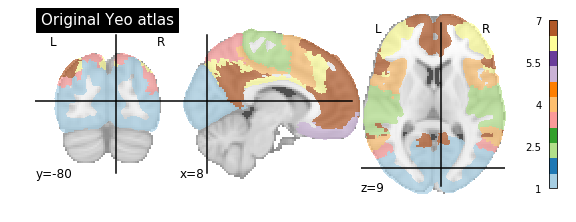

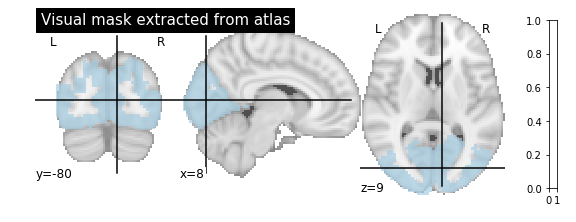

In [15]:
from nilearn import datasets
from nilearn.plotting import plot_roi
%matplotlib inline
from nilearn.image import resample_to_img, load_img, new_img_like
atlas_yeo_2011 = datasets.fetch_atlas_yeo_2011()
atlas_yeo = atlas_yeo_2011.thick_7
atlas = load_img(atlas_yeo)
plot_roi(atlas_yeo, title='Original Yeo atlas',
         cut_coords=(8, -80, 9), colorbar=True, cmap='Paired')

# Select visual cortex, create a mask and resample it to the resolution of the images
mask_visual = new_img_like(atlas, atlas.get_data() == 1)
resampled_mask_visual = resample_to_img(
    mask_visual, mask, interpolation="nearest")

# Plot the mask we will use
plot_roi(resampled_mask_visual, title='Visual mask extracted from atlas',
         cut_coords=(8, -80, 9), colorbar=True, cmap='Paired')

Defining a masker using the mask we just created
------------------------------------------------
We define a nilearn masker that will be used to handle relevant data
For more information, visit : http: // nilearn.github.io / manipulating_images / masker_objects.html

In [16]:
from nilearn.input_data import NiftiMasker
roi_masker = NiftiMasker(mask_img=resampled_mask_visual)
roi_masker.fit()

NiftiMasker(detrend=False, high_pass=None, low_pass=None, mask_args=None,
      mask_img=<nibabel.nifti1.Nifti1Image object at 0x1c16e03dd0>,
      mask_strategy='background', memory=Memory(cachedir=None),
      memory_level=1, sample_mask=None, sessions=None, smoothing_fwhm=None,
      standardize=False, t_r=None, target_affine=None, target_shape=None,
      verbose=0)

Separate the retrieved files into four folds
--------
The train folds used to learn alignment from source subject toward target:

* source train: AP contrasts for subject one
* target train: AP contrasts for subject two

The test folds:

* source test: PA contrasts for subject one, used to predict the corresponding contrasts of subject two
* target test: PA contrasts for subject two, used as a ground truth to score our predictions

In [17]:
im_train_1 = df[df.subject == 'sub-01'][df.acquisition == 'ap'].path.values
im_train_2 = df[df.subject == 'sub-02'][df.acquisition == 'ap'].path.values
im_test_1 = df[df.subject == 'sub-01'][df.acquisition == 'pa'].path.values
im_test_2 = df[df.subject == 'sub-02'][df.acquisition == 'pa'].path.values

/Users/thomasbazeille/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/Users/thomasbazeille/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/thomasbazeille/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/thomasbazeille/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


Define the estimator used to align subjects, fit it and use it to predict
-------------------------------------------------------------------------
To proceed with alignment we can use two methods :
* first we will mask the data in a first step to select the ROI signals we need and then use an estimator working directly on data arrays on the signal extracted. 
* in a second time, we will show how to use the class PairwiseAlignment on niimg directly using the masker we created before that selects specifically a part of data to align and predict

As an estimator, we use ScaledOrthogonalAlignment that is common in the literature under the name hyperalignment (and solve the problem of Procrustes) but other estimators are implemented in fmralign.alignment_methods module

In [18]:
from fmralign.alignment_methods import ScaledOrthogonalAlignment, RidgeAlignment

alignment_class = ScaledOrthogonalAlignment()
# Mask the data and learn alignment from source subject 1 to target subject 2 \
#   on training data
alignment_class.fit(roi_masker.transform(im_train_1),
                    roi_masker.transform(im_train_2))
# Predict test data for subject 2 from subject 1
predicted_data = alignment_class.transform(roi_masker.transform(im_test_1))

Score the prediction of test data without alignment
---------------------------------------------------
To score the quality of prediction we use r2 score on each voxel activation profile across contrasts
This score is 1 for a perfect prediction and can get arbitrarly bad (here we clip it to -1 for bad predictions)

In [19]:
import numpy as np
from sklearn.metrics import r2_score
# Mask the real test data for subject 2 to get a ground truth vector
ground_truth = roi_masker.transform(im_test_2)

# Score the prediction of test data without alignment...
baseline_score = np.maximum(r2_score(
    ground_truth, roi_masker.transform(im_test_1), multioutput='raw_values'), -1)
# ... and using alignment.
aligned_score = np.maximum(r2_score(
    ground_truth, predicted_data, multioutput='raw_values'), -1)

Plotting the prediction quality
--------------------------------

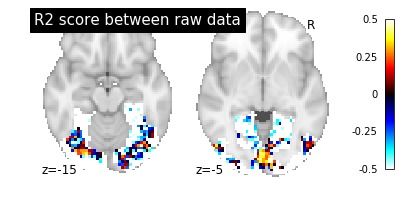

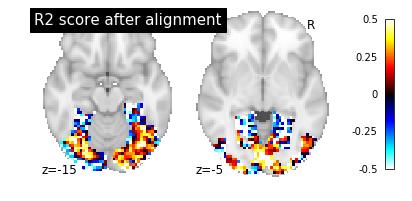

In [20]:
from nilearn.plotting import plot_stat_map
baseline_display = plot_stat_map(roi_masker.inverse_transform(
    baseline_score), display_mode="z", cut_coords=[-15, -5], vmax=0.5)
baseline_display.title("R2 score between raw data")
display = plot_stat_map(
    roi_masker.inverse_transform(
        aligned_score), display_mode="z", cut_coords=[-15, -5], vmax=0.5)
display.title("R2 score after alignment")

We can see on the plot that after alignment, the prediction made for one subject data, informed by another subject are greatly improved.

Aligning on ROI directly with PairwiseAlignment
---------------------------------------------------
Instead of masking the data and applying alignment separately, we could also be have done the same directly using PairwiseAlignment() with the visual mask, on nifti images.

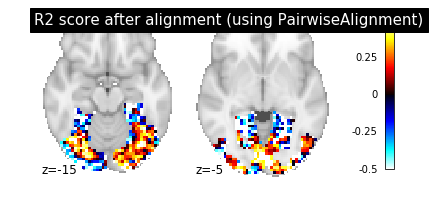

In [21]:
from fmralign.pairwise_alignment import PairwiseAlignment

alignment_estimator = PairwiseAlignment(
    alignment_method='scaled_orthogonal', n_pieces=1, mask=roi_masker)
alignment_estimator.fit(im_train_1, im_train_2)
directly_predicted_img = alignment_estimator.transform(im_test_1)
directly_aligned_score = np.maximum(r2_score(
    ground_truth, roi_masker.transform(directly_predicted_img), multioutput='raw_values'), -1)
display = plot_stat_map(
    roi_masker.inverse_transform(
        directly_aligned_score), display_mode="z", cut_coords=[-15, -5], vmax=0.5)
display.title("R2 score after alignment (using PairwiseAlignment)")
